## BKM (2018)

- Author: Joao B. Duarte
- Last Update: 29/11/2020

"Exploiting MIT shocks in heterogeneous-agent economies: the impulse response as a numerical derivative" by Boppart,
Krusell and Mitman.

- Assume model is linear (certainty equivalence holds)
- Derive IRF based on nonlinear MIT-shock
- **key idea**: if model is linear, can use Wold Decomposition which implies aggregate variables can be expressed as
linear combination of past shocks:

$$y_t = e_{z,t}\gamma_0 + e_{z,t-1}\gamma_1 + \dots$$

But $\gamma$ are exactly the IRF coefficients.

Hence, given one IRF, we can simulate all aggregates. (Turn IRF around!)

If more shock types (z and χ), only one IRF per shock needed (linearity implies addibility)!

$$y_t = e_{z,t}\gamma_{z,0} +  e_{χ,t}\gamma_{χ,0}  + e_{z,t-1}\gamma_{z,1} + e_{χ,t-1}\gamma_{χ,1} + \dots$$

### KS revisited

In [34]:
# Import Libraries
import numpy as np
import scipy.optimize as opt
from scipy.interpolate import interp1d
from quantecon.markov import DiscreteDP
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc
plt.style.use({'figure.facecolor':'white'})
rc('text', usetex=True)
%config InlineBackend.figure_format = 'retina'


gamma = 2
mu = 0.1
alpha = 0.33
phi = -1.0
beta = 0.96
delta = 0.05
a_min = -3.0
a_max = 18.0
A = 1.0
L = 1.0
N = 100

P = np.array([[0.9,0.1], [0.9, 0.1]])

agrid = np.linspace(a_min,np.log(a_max-phi+1),N)
a_vals = np.exp(agrid)+phi-1

def rd(K, A = 1.0):
    return A * alpha * (L / K)**(1 - alpha) - delta

def r_to_w(r, A = 1.0):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - alpha) * (A * alpha / (r + delta))**(alpha / (1 - alpha))

def policy(r0, w0, r1, w1):
    ag1 = a_vals.copy()
    ab1 = a_vals.copy()
    ag = a_vals.copy()
    ab = a_vals.copy()
    metric = 1

    while metric > 1e-6:

        gg = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
        gb = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

        Eg = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
        Eb = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

        ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
        ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)

        metric = np.array(([abs(ag1-ag),abs(ab1-ab)])).max()

        ag = ag1
        ab = ab1

    return gg, gb


def makeTransition_M(gg, gb):
    a1g_star, a1b_star = np.maximum(gg(a_vals),phi), np.maximum(gb(a_vals),phi)
    F = interp1d(a_vals,a_vals, kind = 'next', fill_value = a_vals[-1], bounds_error=False)
    a1gd_star = F(np.maximum(gg(a_vals),phi))
    a1bd_star = F(np.maximum(gb(a_vals),phi))

    Tg = np.zeros([N,N])
    Tb = np.zeros([N,N])

    for i in range(N):

        ixg = np.where(a_vals==a1gd_star[i])[0][0]
        Tg[i,ixg] = 1-(a_vals[ixg]-a1g_star[i])/(a_vals[ixg]-a_vals[ixg-1])
        if Tg[i,ixg] > 1:
            Tg[i,ixg] = 1.0
        Tg[i,ixg-1] = 1-Tg[i,ixg]

        ixb = np.where(a_vals==a1bd_star[i])[0][0]
        if ixb == 0:
            Tb[i,ixb] = 1.0
        else:
            Tb[i,ixb] = 1-(a_vals[ixb]-a1b_star[i])/(a_vals[ixb]-a_vals[ixb-1])
            if Tb[i,ixb] > 1:
                Tb[i,ixb] = 1.0
            Tb[i,ixb-1] = 1-Tb[i,ixb]
    M = np.concatenate((np.concatenate((P[0,0]*Tb, P[0,1]*Tb), axis=1),np.concatenate((P[1,0]*Tg,P[1,1]*Tg), axis=1)), axis=0)
    return M

def GetStationaryDist(M):
    eval,evec = np.linalg.eig(M.T)
    i = np.argmin(np.abs(eval-1.0))
    D = np.array(evec[:,i]).flatten()
    assert np.max(np.abs(np.imag(D))) < 1e-6
    D = np.real(D)  # just recasts as float
    D = D/D.sum()
    D[D<0]=0
    return D/D.sum()

def agr_capital(dist):
    a_dist = dist[:N]+dist[N:]
    return np.dot(a_vals.T, a_dist)

def prices_to_capital(r):
    gg, gb = policy(r, r_to_w(r), r, r_to_w(r))
    M = makeTransition_M(gg,gb)
    dist = GetStationaryDist(M)
    K = agr_capital(dist)
    return K

def equilibrium_ss():
    res = lambda K: K - prices_to_capital(rd(K))
    Kss_certain =  ((1/beta-1+delta)/alpha)**(1./(alpha-1))
    sol  = opt.root_scalar(res, bracket = [0.8*Kss_certain,1.2*Kss_certain], method = 'brentq').root
    return sol


def policy_back(r0, w0, r1, w1, gg, gb):

    Eg = beta*(1+r1)*( P[1,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[1,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )
    Eb = beta*(1+r1)*( P[0,1]*(a_vals*(1+r1)+w1-np.maximum(gg(a_vals),phi))**(-gamma)+P[0,0]*(a_vals*(1+r1)+mu*w1-np.maximum(gb(a_vals),phi))**(-gamma) )

    ag1 = (Eg**(-1/gamma)-w0+a_vals)/(1+r0)
    ab1 = (Eb**(-1/gamma)-mu*w0+a_vals)/(1+r0)

    gg1 = interp1d(ag1, a_vals,  'linear', fill_value = 'extrapolate')
    gb1 = interp1d(ab1, a_vals,  'linear',  fill_value = 'extrapolate')

    return gg1, gb1

### Find Stationary Equilibrium

In [35]:
Kss = equilibrium_ss()
print(f'Equilibrium capital is {Kss}')

Equilibrium capital is 7.044756293424861


In [36]:
r = rd(Kss)
w = r_to_w(r)
gg, gb = policy(r, w, r, w)
M = makeTransition_M(gg, gb)
dist = GetStationaryDist(M)


In [37]:
s = 100
# AR(1) process for TFP
def A1(z, rho=0.5):
    return (1-rho) + z*rho
As = [1.01]
for i in range(1,s+1):
    As.append(A1(As[i-1]))
As = np.array(As)

In [38]:
# Guess K sequence
K0s = np.ones(s+1)*Kss
gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

def update_agreggates(K0s, As):
    # Update Prices
    rs = rd(K0s, As)
    ws = r_to_w(rs, As)

    # Update Policies
    ggs = [None]*s
    ggs.insert(s, gg_ss)

    gbs = [None]*s
    gbs.insert(s, gb_ss)

    for i in range(s,0,-1):
        r1 = rd(K0s[i], As[i])
        r0 = rd(K0s[i-1], As[i-1])
        w1 = r_to_w(r1, As[i])
        w0 = r_to_w(r0, As[i-1])
        gg1, gb1 = policy_back(r0, w0, r1, w1, ggs[i], gbs[i])
        ggs[i-1] = gg1
        gbs[i-1] = gb1

    Ms = [None]*s

    for i in range(0,s,1):
        Ms[i]= makeTransition_M(ggs[i], gbs[i])

    # Update Distributions
    dists = [None]*(s+1)
    dists[0] = dist

    for i in range(1,s+1):
        dists[i] = np.dot(Ms[i-1].T,dists[i-1].reshape((200,1)))

    K1s = [None]*s
    K1s.insert(s, Kss)

    for i in range(0,s,1):
        K1s[i] = agr_capital(dists[i+1])[0]

    return np.array(K1s), ggs, gbs, dists

def equilibrium_trans(Kguess, As):
    dif = 1
    print('Computing MIT-shock IRF...')
    while dif>1e-6:
        aggK, ggs, gbs, dists = update_agreggates(Kguess, As)
        dif = np.amax(abs(aggK - Kguess))
        Kguess = 0.2*aggK + 0.8*Kguess
    print('\n ...done!')
    return aggK, ggs, gbs, dists

aggK, ggs, gbs, dists = equilibrium_trans(K0s, As)


Computing MIT-shock IRF...

 ...done!


### Simulate!


In [39]:
T = 1000
shocks = np.random.uniform(-1, 1, T)

Ks = np.ones(T-s)
for i in range(0,T-s):
    Ks[i] = np.dot(shocks[i:i+s+1],(aggK[::-1]-Kss))

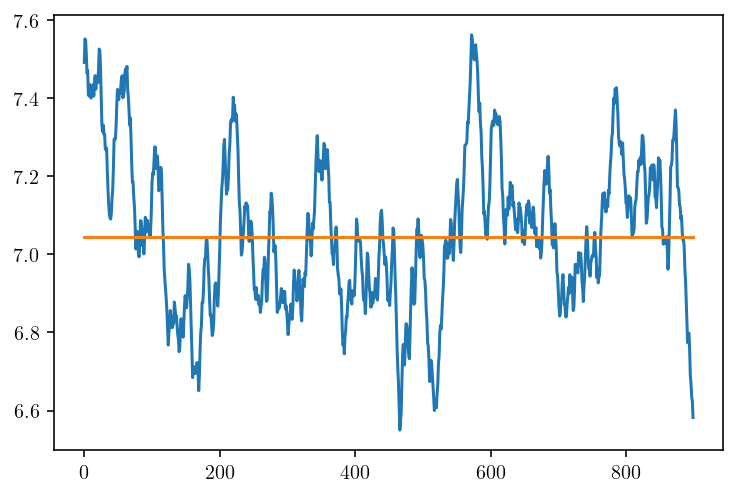

In [40]:
plt.plot(np.arange(len(Ks)), (1+Ks)*Kss)
plt.plot(np.arange(len(Ks)), Kss*np.ones(len(Ks)))
plt.show()

### Test linearity assumption

In [46]:
def MIT(shock):
    As = [1+shock]
    for i in range(1,s+1):
        As.append(A1(As[i-1]))
    As = np.array(As)

    K0s = np.ones(s+1)*Kss
    gg_ss, gb_ss = policy(rd(Kss), r_to_w(rd(Kss)), rd(Kss), r_to_w(rd(Kss)))

    aggK, ggs, gbs, dists = equilibrium_trans(K0s, As)

    plt.plot(np.arange(len(aggK)), aggK-Kss, linestyle='--',
             label=r'$e_z$:'+str(shock))

Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!
Computing MIT-shock IRF...

 ...done!


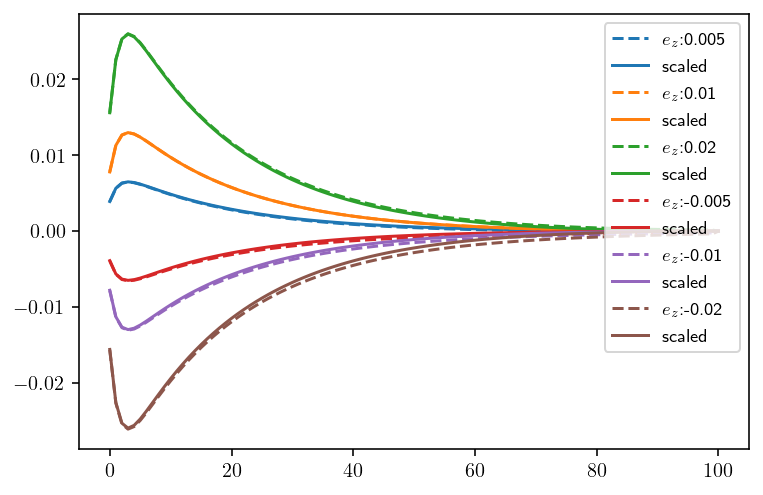

In [59]:
As0 = [1+0.01]
for i in range(1,s+1):
    As0.append(A1(As0[i-1]))
As0 = np.array(As0)
irf = equilibrium_trans(K0s, As0)[0]-Kss

shocks = [0.005, 0.01,  0.02]
for i,shock in enumerate(shocks):
    MIT(shock)
    plt.plot(np.arange(len(aggK)), irf*shock/0.01,
             label = 'scaled', c='C'+str(i))
for i,shock in enumerate(shocks):
    MIT(-shock)
    plt.plot(np.arange(len(aggK)), -irf*shock/0.01,
             label = 'scaled', c='C'+str(i+3))
plt.legend(fontsize=9, loc='upper right')
plt.show()

The linear approximation is reasonable for small shocks as the dashed lines (nonlinear IRFs) are close to the solid lines (scaled
nonlinear IRF, i.e. assuming linearity)

Lets try a very large shock

Computing MIT-shock IRF...

 ...done!


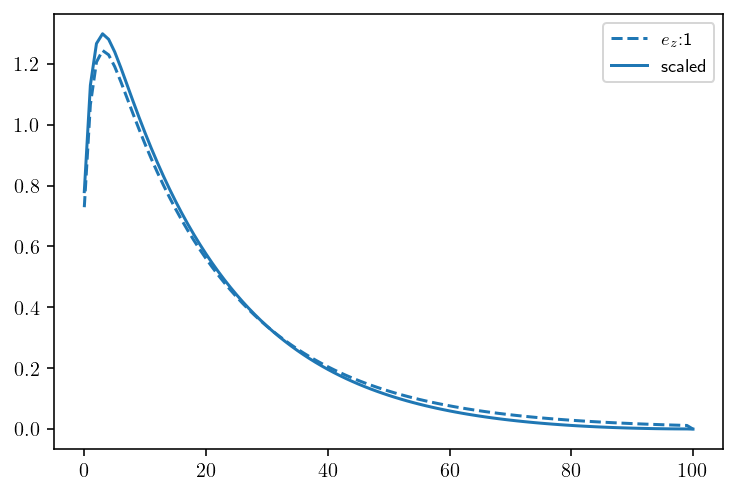

In [63]:
shocks = [1]
for i,shock in enumerate(shocks):
    MIT(shock)
    plt.plot(np.arange(len(aggK)), irf*shock/0.01,
             label = 'scaled', c='C'+str(i))
plt.legend(fontsize=9, loc='upper right')
plt.show()
